In [90]:
import numpy as np
from genetic_algorithm_base import GeneticAlgorithm
from mido import Message, MidiFile, MidiTrack
import matplotlib.pyplot as plt

def array_to_midi(melody, reference_note, output_file, bpm = 120):
    """
    Convert a melody to a MIDI file.

    Args:
        melody (np.array): Numpy array with shape (n, 3) where n is the number of notes. Each row contains the position, relative pitch and duration of a note.
        reference_note (int): The MIDI pitch of the reference note.
        output_file (str): The output MIDI file name.
    """
    # Create a new MIDI file and track
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    # Default settings
    ticks_per_beat = mid.ticks_per_beat  # MIDI resolution

    # Convert melody to MIDI events
    for i in range(melody.shape[0]):
        #position = melody[i, 0]
        rel_pitch = int(melody[i, 1])
        duration = melody[i, 2]

        # Calculate the absolute MIDI pitch
        midi_pitch = reference_note + rel_pitch
        duration_ticks = int(duration * ticks_per_beat)
        
        # Add the MIDI note on event
        track.append(Message('note_on', note=midi_pitch, velocity=100, time=0))
        track.append(Message('note_off', note=midi_pitch, velocity=100, time=duration_ticks))

    # Save the MIDI file
    mid.save(output_file)
    print(f"MIDI file saved as {output_file}")

def find_common_positions(melody1, melody2):
    return np.intersect1d(melody1[:, 0], melody2[:, 0])

little_fugue_melody = np.array([
    [0, 0, 1],
    [1, 7, 1],
    [2, 3, 1.5],
    [3.5, 2, 0.5],

    [4, 0, 0.5],
    [4.5, 3, 0.5],
    [5, 2, 0.5],
    [5.5, 0, 0.5],
    [6, -1, 0.5],
    [6.5, 2, 0.5],
    [7, -5, 1],
])

pos_bach = little_fugue_melody[:, 0]
pitch_bach = little_fugue_melody[:, 1]
dur_bach = little_fugue_melody[:, 2]

reference_note = 60  # C4
output_file = "melody.mid"
array_to_midi(little_fugue_melody, reference_note, output_file)

MIDI file saved as melody.mid


# Define fitness, crossover & mutation

In [115]:
def fitness(melody):
    '''Evaluate the fitness of a melody'''
    positions = melody[:, 0]
    pitches = melody[:, 1].astype(int)
    durations = melody[:, 2]

    common_indices = find_common_positions(melody, little_fugue_melody)

    # ========================================================
    # Scale score
    # ========================================================
    scale = [0, 2, 3, 5, 7, 8, 11]

    scale_score = 0
    for i in range(len(pitches)):
        if pitches[i] % 12 in scale:
            scale_score += 1
    scale_score /= len(pitches)

    # ========================================================
    # Interval score
    # ========================================================

    interval_score = 0
    for i in common_indices:
        if abs(pitches[i] - little_fugue_melody[i, 1]) in [0, 1, 2, 6, 10, 11]:
            interval_score -= 1
        elif abs(pitches[i] - little_fugue_melody[i, 1]) in [3, 4, 8, 9]:
            interval_score += 1

    interval_score /= len(common_indices)

    # ========================================================
    # Overlap score
    # ========================================================

    overlap = len(common_indices) / len(pitches)
    overlap_score = np.exp(-(overlap - 0.5)**2/(2*0.2**2))

    # ========================================================
    # Step size score
    # ========================================================

    n_large_steps = 0
    n_small_steps = 0
    for i in range(1, len(pitches)):
        diff = abs(pitches[i] - pitches[i-1])
        if diff >= 8:
            n_large_steps += 1
        elif diff <= 2:
            n_small_steps += 1

    large_steps_percentage = n_large_steps / len(pitches)
    small_steps_percentage = n_small_steps / len(pitches)

    step_score = np.exp(-(large_steps_percentage - 0.25)**2/(2*0.1**2)) + np.exp(-(small_steps_percentage - 0.7)**2/(2*0.1**2))
    step_score /= 2

    # ========================================================
    # Note repetition score
    # ========================================================
    note_repetitions = 0
    for i in range(1, len(pitches)):
        if pitches[i] == pitches[i-1]:
            note_repetitions += 1

    note_repetitons_score = np.exp(-note_repetitions/len(pitches))

    # ========================================================
    # Note length score
    # ========================================================

    note_length_score = np.sum(np.where(durations <= 1, True, False)) / len(durations)

    # ========================================================
    # Total score
    # ========================================================
    
    total_score = scale_score + interval_score + overlap_score + step_score + note_repetitons_score
    total_score /= 5

    return total_score

def find_common_positions(melody1, melody2):
    '''Find the common positions between two melodies.'''
    # find common positions
    n = max(melody1.shape[0], melody2.shape[0])
    pos1 = np.zeros(n)
    pos2 = np.zeros(n)

    pos1[:melody1.shape[0]] = melody1[:, 0]
    pos2[:melody2.shape[0]] = melody2[:, 0]
    
    # indices of common positions
    return np.arange(n)[np.where(pos1 == pos2, True, False)]

def crossover(melody1, melody2):
    '''Crossover two melodies to produce a child melody.'''
    idx = np.random.choice(find_common_positions(melody1, melody2))

    child = np.empty((0, 3))
    child = np.vstack([child, melody1[:idx]])
    child = np.vstack([child, melody2[idx:]])

    return child

def mutate(melody):
    '''Randomly mutate a melody.'''
    mutated_melody = melody.copy()

    # pitch mutations
    for _ in range(5):
        idx = np.random.randint(0, melody.shape[0])
        mutated_melody[idx, 1] += np.random.choice([-1, 1])

    return mutated_melody

def generate_random_melody(length, min_pitch, max_pitch):
    '''Generate a random melody of length `length` in quarter notes and pitch range [min_pitch, max_pitch].'''
    melody = np.empty((0, 3))
    pos = 0

    while pos < length:
        duration = np.random.choice([0.25, 0.5, 1])
        duration = np.clip(pos + duration, 0, length) - pos
        pitch = np.random.randint(min_pitch, max_pitch)
        event = np.array([pos, pitch, duration])
        melody = np.vstack([melody, event])
        pos += duration
    
    return melody

# Evolve population

MIDI file saved as melody.mid


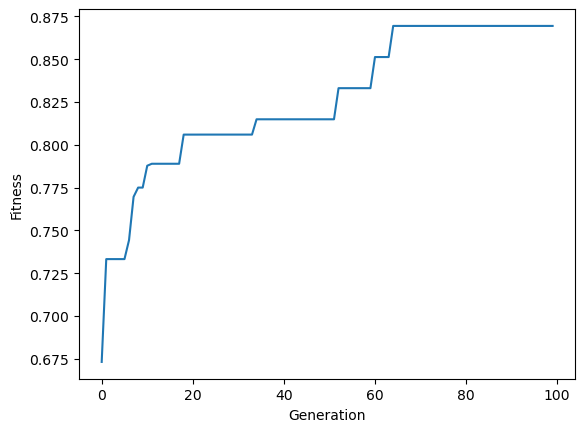

In [118]:
initial_population = [generate_random_melody(8, -12, 12) for _ in range(200)]

GA = GeneticAlgorithm(initial_population,
                      fitness_function = fitness,
                      crossover_function = crossover,
                      mutation_function = mutate)

final_population, final_fitness, fitness_evolution = GA.evolve(number_of_generations=100, number_of_parents=50, number_of_offspring=100)

array_to_midi(final_population[np.argmax(final_fitness)], 48, output_file)

plt.plot(fitness_evolution)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()

In [113]:
GA.evaluate_population_fitness()
GA.population_fitness

array([0.875     , 0.875     , 0.875     , 0.875     , 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500001,
       0.87500001, 0.87500001, 0.87500001, 0.87500001, 0.87500